# XGBoost
Extreme Gradient Boost. Implementation of Gradient Boosted Decision Trees algorithm.

Predicts target variables by combining estimates of [multiple weak models](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTiJcE6PULQt64mXKBr-aeDmJreG2JbMm1nNb4PVHuHrr_tGAJU4Q).

XGBoost is supervised method for both regression and classification.

Ensemble models: Combine multiple models to get the result.

Process
1. Choose a base model
2. Calculate errors for each observation
3. Train an new model to predict the errors
4. Add errors from the model in previous step to the enemble of models 
5. Repeat 2-4

Good
* Can handle pretty dirty data
* Fast predictions
* Detects even non-linear relations
* Possibility to exaplain the model

Bad
* Slow training
* Predicts poorly observations that don't exist in training data

Most important function parameters
* max depth
* min child weight
* gamma
* eta

## Example
Create binary classified data. Class 0 will be in squared ared in two dimensional space marked with red color. Class 1 data is in two solid regions at the left and top of the space marked with blue color. So three regions in total.

The data can not be classfied with linear model, but some kind of rule based model might predict the classes pretty easily. Let's apply XGBoost to this problem.

Some noise had been added as sharp boundaries between regions would result accuracy of 100%.

Inspired by [this blog](https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/).

### Libraries

In [1]:
# First XGBoost model for Pima Indians dataset
import pandas as pd
import numpy as np
from numpy.random import randint

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Helper functions

In [2]:
def draw_regions():
    
    a = 0.2
    
    rect_0 = Rectangle((x1_min[0], x2_min[0]), x1_max[0]-x1_min[0], x2_max[0]-x2_min[0], alpha=a, color='blue')
    rect_1 = Rectangle((x1_min[1], x2_min[1]), x1_max[1]-x1_min[1], x2_max[1]-x2_min[1], alpha=a, color='blue')
    rect_2 = Rectangle((x1_min[2], x2_min[2]), x1_max[2]-x1_min[2], x2_max[2]-x2_min[2], alpha=a, color='red')
    plt.gca().add_patch(rect_0)
    plt.gca().add_patch(rect_1)
    plt.gca().add_patch(rect_2)

### Generate data

In [3]:
#Number of observations in different regions
n = [50, 50, 100]
n_total = sum(n)

#Magnitude of random noise
r = 4

#Boundaries for 3 regions of data. 2 regions are class 1 and the third region is class 0.
x1_min = [0, 25, 25]
x1_max = [25, 100, 100]
x2_min = [0, 75, 0 ]
x2_max = [75, 100, 75]

#Create region data. Add little noise
x1 = np.concatenate([
    randint(x1_min[0], x1_max[0]+r, n[0]), 
    randint(x1_min[1], x1_max[1], n[1]),
    randint(x1_min[2]-r, x1_max[2], n[2])
])

x2 = np.concatenate([
    randint(x2_min[0], x2_max[0], n[0]), 
    randint(x2_min[1]-r, x2_max[1], n[1]),
    randint(x2_min[2], x2_max[2]+r, n[2])
])

y = np.concatenate([
    np.repeat(1, n[0]), 
    np.repeat(1, n[1]),
    np.repeat(0, n[2]),
])

#Create data
df = pd.DataFrame({
    'x1': x1,
    'x2': x2, 
    'y' : y
})

#Color by y value
df['color'] = np.where(df['y'], 'b', 'r')
display(df.head())

,x1,x2,y,color
0,21,9,1,b
1,4,39,1,b
2,2,3,1,b
3,19,48,1,b
4,5,38,1,b


### Visualize data

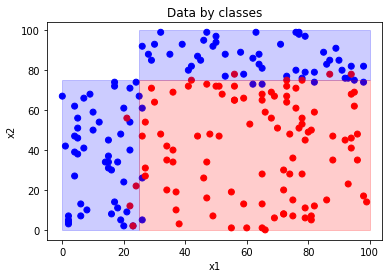

In [4]:
#Plot data
plt.scatter(df['x1'], df['x2'], c=df['color'])
plt.title('Data by classes')
plt.xlabel('x1')
plt.ylabel('x2')
draw_regions()
plt.show()

### Fit the model

In [5]:
# split data into X and y
X = df[['x1', 'x2']]
Y = df['y']

#Split train and test data
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#Train the model
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Predict

In [6]:
#Predict
y_pred = model.predict(X_test)

#Create data frame for predictions
df_pred = X_test.copy()
df_pred['actual'] = y_test
df_pred['predicted'] = y_pred
df_pred['correct'] = df_pred['actual'] == df_pred['predicted']
df_pred['color'] = np.select(
    [
        df_pred['correct']==True, 
        (df_pred['correct']==False) & (df_pred['actual']==1),
        (df_pred['correct']==False) & (df_pred['actual']==0)
    ],
    ['lightgray', 'blue', 'red'], 
)
#df_pred['color'] = np.where(df_pred['correct'], 'lightgray', 'black')
display(df_pred.head())

,x1,x2,actual,predicted,correct,color
86,82,79,1,1,True,lightgray
120,78,56,0,0,True,lightgray
22,18,34,1,1,True,lightgray
11,5,56,1,1,True,lightgray
195,66,0,0,0,True,lightgray


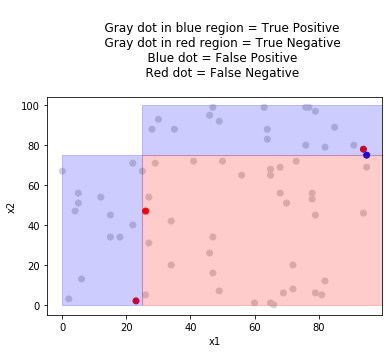

In [7]:
#Plot predictions
plt.scatter(df_pred['x1'], df_pred['x2'], color=df_pred['color'])
plt.title("""
    Gray dot in blue region = True Positive
    Gray dot in red region = True Negative
    Blue dot = False Positive
    Red dot = False Negative
""")
plt.xlabel('x1')
plt.ylabel('x2')
draw_regions()
plt.show()

In [8]:
#Calculate accuracy
accuracy = accuracy_score(df_pred['actual'], df_pred['predicted'])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.94%


### Summary
XGBoost found the pretty well the decision boundaries. A few predicted data points was incorrectly classified due to the random noise. The good new is, the mis-classified data points are close to the boundaries.